In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Import and explore the data

In [0]:

df = pd.read_csv('cansim_monthlyRetailSales.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')

In [54]:
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


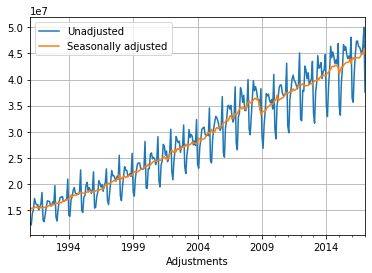

In [57]:
df.plot()
plt.grid()

In [0]:
# a noticeable bend in the trend corresponds to the 2008 financial crisis

In [0]:
from pandas.tseries.offsets import MonthEnd

In [0]:
df['Adjustments']=pd.to_datetime(df['Adjustments'])+MonthEnd(1)

In [0]:
df = df.set_index('Adjustments')

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
mms = MinMaxScaler()

In [0]:
# let's use the data up to 2011-01-01 as training data and test our models on the data afterwards
split_date = pd.Timestamp('2011-01-01')

In [0]:
train = df.loc[:split_date,['Unadjusted']]
test = df.loc[split_date:,['Unadjusted']]

In [17]:
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


In [0]:
train_sc = mms.fit_transform(train)
test_sc = mms.transform(test)

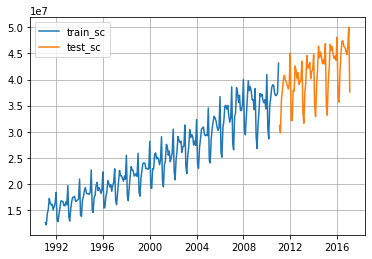

In [56]:
plt.plot(train)
plt.plot(test)
plt.grid()
plt.legend(['train_sc','test_sc'])

### Fully connected predictor

In [0]:
# Let's start with a fully connected model. 
# We will feed the data from each month as the input feature, and the data from the following month will serve as the output.

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [0]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping  

In [38]:
K.clear_session()

model = Sequential()
model.add(Dense(12,input_shape=(1,),activation='relu'))
# we don't apply any activation to the output layer because we are dealing with a regression problem
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [39]:
# The EarlyStopping callback has detected that 10 iterations is sufficient to reach the plateau
model.fit(X_train,y_train,epochs=200,batch_size=2,callbacks=[EarlyStopping(monitor='loss',patience=1,verbose=1)])

Epoch 1/200
239/239 [==============================] - 0s 2ms/step - loss: 0.0426
Epoch 2/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0138
Epoch 3/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 4/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 5/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 6/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 7/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 8/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 9/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 10/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 00010: early stopping


In [0]:
y_pred = model.predict(X_test)

In [41]:
y_pred.shape

(72, 1)

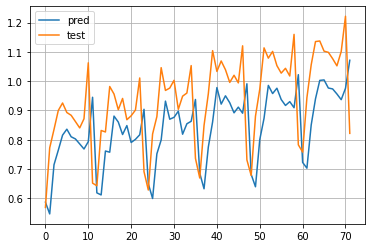

In [42]:
plt.plot(y_pred)
plt.plot(y_test)
plt.grid()
plt.legend(['pred','test'])

In [0]:
# the fully connected predictor is no good. Let's try recurrent predictor with data fed on a one-to-one principle

### Recurrent predictor

In [45]:
X_train.shape

(239, 1)

In [48]:
# For a RNN we need to present the input as a 3D tensor with shape (batch_size, timesteps, input_dim)

X_train[:,None].shape

(239, 1, 1)

In [0]:
X_train_t = X_train[:,None]
X_test_t = X_test[:,None]

In [0]:
K.clear_session()

model = Sequential()

model.add(LSTM(6,input_shape=(1,1)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')


In [51]:
model.fit(X_train_t,y_train,epochs =100,batch_size=1,verbose=1,
          callbacks=[EarlyStopping(monitor='loss',patience=1,verbose=1)])

Epoch 1/100
239/239 [==============================] - 2s 6ms/step - loss: 0.1378
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0450
Epoch 3/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0353
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0280
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0217
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0169
Epoch 7/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0135
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0116
Epoch 9/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0107
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0104
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0101
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0102
Epoch 00012: 

In [0]:
y_pred = model.predict(X_test_t)

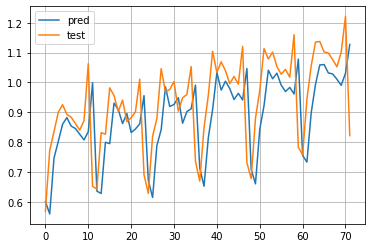

In [53]:
plt.plot(y_pred)
plt.plot(y_test)
plt.grid()
plt.legend(['pred','test'])

In [0]:
# not a good prediction either. Let's try RNN on rolling windows.

### Recurrent predictor on rolling windows

A rolling window allows one to use a chronological sequence of data points as a single input as opposed to just one point.

In [0]:
df_train_sc = pd.DataFrame(train_sc,columns = ['scaled'],index = train.index)
df_test_sc = pd.DataFrame(test_sc,columns = ['scaled'],index = test.index)

In [0]:
df_train_sc.tail()

,scaled
Adjustments,
2010-08-31,0.814394
2010-09-30,0.799167
2010-10-31,0.802101
2010-11-30,0.814829
2010-12-31,1.000000


In [0]:
for s in range(1,13):
  df_train_sc['by {}'.format(s)] = df_train_sc['scaled'].shift(s)
  df_test_sc['by {}'.format(s)] = df_test_sc['scaled'].shift(s)

In [0]:
df_train_sc.head(13)

,scaled,by 1,by 2,by 3,by 4,by 5,by 6,by 7,by 8,by 9,by 10,by 11,by 12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [0]:
# we ignore the first 12 months in the train and test periods because they contain null values  
X_train = df_train_sc.dropna().drop('scaled',axis =1)
y_train = df_train_sc.dropna()['scaled']

X_test = df_test_sc.dropna().drop('scaled',axis=1)
y_test = df_test_sc.dropna()['scaled']

In [0]:
import keras.backend as K
from keras.layers import Dense,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [0]:
X_train = X_train.values
X_test = X_test.values

# we consider a many-to-one RNN architecture with 12 data points fed at a time
X_train_t =X_train.reshape(X_train.shape[0],12,1)
X_test_t = X_test.reshape(X_test.shape[0],12,1)

In [0]:
K.clear_session()

model = Sequential()

model.add(LSTM(6,input_shape = (12,1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer ='adam')

model.summary()







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train_t,y_train,batch_size=32,epochs = 100,batch_size=1,verbose=1,
          callbacks=[EarlyStopping(monitor='loss',patience=1,verbose=1)])

In [0]:
y_pred = pd.DataFrame(model.predict(X_test_t),index = y_test.index)

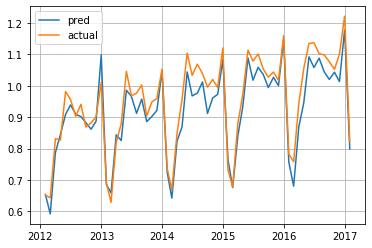

In [0]:
plt.plot(y_pred)
plt.plot(y_test)
plt.grid()
plt.legend(['pred','actual'])

### Hands down, the RNN on Rolling Windows has given the best result!